In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import cv2
from pycocotools.coco import COCO
import datetime as dt
from PIL import Image
import time
import seaborn as sns
from tempfile import TemporaryDirectory
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models
from torchvision.transforms import ToTensor
from torchvision import transforms, utils
from torchvision.transforms.transforms import RandomAutocontrast, Grayscale, RandomRotation, RandomPerspective, RandomInvert
from torchvision.transforms import Resize
from torchvision.io import read_image, ImageReadMode
from torch import nn

import skimage.io as io

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

plt.ion()

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
TRAIN_SIZE = .75
BATCH_SIZE = 16
#T_BATCH_SIZE = 10
#IMG_SIZE = 512
#IMG_CHANNELS = 1
dataDir = 'drive/MyDrive/Colab Notebooks/samolet/data/train/images/'
cellDir = 'drive/MyDrive/Colab Notebooks/samolet/data/train/cells/'
modelDir = 'drive/MyDrive/Colab Notebooks/samolet/data/train/model/'
dataType = 'default'
annFile = '{}annotations/instances_{}.json'.format(dataDir,dataType)
ann_path = 'drive/MyDrive/Colab Notebooks/samolet/data/train/images/annotations/instances_default.json'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
coco = COCO(annFile)
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

loading annotations into memory...
Done (t=3.01s)
creating index...
index created!
COCO categories: 
window empty filled

COCO supercategories: 



## Формирование датафрейма с путями к изображениям и меткам на них

In [6]:
df_anns = pd.DataFrame(coco.anns).T
df_anns.set_index("id", inplace=True)
df_anns["rotation"] = df_anns["attributes"].apply(lambda x: list(x.values())[1])
df_anns.drop(columns=["segmentation", "iscrowd", "attributes"], inplace=True)
df_anns.head()

,image_id,category_id,area,bbox,rotation
id,,,,,
1,1,2,12677.0917,"[98.87, 141.25, 110.63, 114.59]",0.0
2,1,2,16279.1769,"[723.17, 184.07, 130.83, 124.43]",0.0
3,1,2,13944.2534,"[475.7, 48.84, 116.62, 119.57]",0.0
4,1,2,13847.1183,"[593.81, 62.38, 118.89, 116.47]",0.0
5,1,2,10862.957,"[0.0, 259.95, 81.34, 133.55]",0.0


In [7]:
df_anns['rotation'].unique()

array([  0. , 359.2,   2.7, 358.6,   1.2,   1. , 358.5,   0.9,   0.8,
       357.9])

**Не думаю, что столбец rotation нам чем-то поможет**

In [8]:
df_images = pd.DataFrame(coco.imgs).T
df_images.rename({"id" : "image_id"}, axis=1, inplace=True)
df_images.set_index("image_id", inplace=True)
df_images.drop(columns=["license", "flickr_url", "coco_url", "date_captured"], inplace=True)
df_images.head()

,width,height,file_name
image_id,,,
1,854,572,0000019949building.jpg
2,881,720,0000019869building.jpg
3,847,544,0000019458building.jpg
4,303,600,0000019455building.jpg
5,869,676,0000019431building.jpg


In [9]:
df_cats = pd.DataFrame(coco.cats).T
df_cats.rename({"id" : "category_id"}, axis=1, inplace=True)
df_cats.set_index("category_id", inplace=True)
df_cats.drop(columns="supercategory",inplace=True)
df_cats.head()

,name
category_id,
1,window
2,empty
3,filled


In [10]:
df = df_anns
df = df.merge(right=df_images, left_on="image_id", right_index=True)
df = df.merge(right=df_cats, left_on="category_id", right_index=True)
df.rename({"name" : "category"}, axis=1, inplace=True)
df.rename({"file_name" : "filename"}, axis=1, inplace=True)
df.head()

,image_id,category_id,area,bbox,rotation,width,height,filename,category
id,,,,,,,,,
1,1,2,12677.0917,"[98.87, 141.25, 110.63, 114.59]",0.0,854,572,0000019949building.jpg,empty
2,1,2,16279.1769,"[723.17, 184.07, 130.83, 124.43]",0.0,854,572,0000019949building.jpg,empty
3,1,2,13944.2534,"[475.7, 48.84, 116.62, 119.57]",0.0,854,572,0000019949building.jpg,empty
4,1,2,13847.1183,"[593.81, 62.38, 118.89, 116.47]",0.0,854,572,0000019949building.jpg,empty
5,1,2,10862.957,"[0.0, 259.95, 81.34, 133.55]",0.0,854,572,0000019949building.jpg,empty


In [11]:
df.isna().sum()

image_id       0
category_id    0
area           0
bbox           0
rotation       0
width          0
height         0
filename       0
category       0
dtype: int64

In [12]:
df.shape

(38331, 9)

In [13]:
#cococo = datasets.CocoDetection(root = dataDir, annFile = 'drive/MyDrive/Colab Notebooks/samolet/data/train/images/annotations/instances_default.json')

## Обрезка ячеек и подготовка датасета с ячейками

In [ ]:
image_names = []
targets = []
for filename in os.listdir(dataDir):
  if 'annotations' not in filename.lower():
    boxes = list(df.loc[df['filename']==filename]['bbox'])
    label = list(df.loc[df['filename']==filename]['category_id'])
    path = dataDir + filename
    img = cv2.imread(path)
    count = 0
    for b in boxes:
      b = [int(_) for _ in b]
      cell = img[b[1]:b[1]+b[3], b[0]:b[0]+b[2]]
      cell_name = re.sub('.jpg', '', filename.lower()) + '_cell_' + str(count) + '.png'
      cell_path = cellDir + cell_name
      #cv2.imwrite(cell_path, cell) раскомментировать один раз, для формирования папки с нарезанными ячейками
      image_names.append(cell_name)
      targets.append(label[count])
      count += 1
    #print('cells found ', count)

## Запись датафрейма для pytorch

In [15]:
descr = pd.DataFrame(data={
    'file': image_names,
    'target': targets})
descr['target'] = descr['target'] - 1
#descr.to_csv(cellDir + 'data.csv') #раскомментировать один раз, для формирования папки с нарезанными ячейками

In [46]:
description = pd.read_csv(cellDir + 'data.csv')
class_names = {0: 'window', 1: 'empty', 2: 'filled'}
description = description.drop('Unnamed: 0', axis=1)
description.head()

,file,target
0,0000016785building_cell_0.png,1
1,0000016785building_cell_1.png,1
2,0000016785building_cell_2.png,0
3,0000016785building_cell_3.png,0
4,0000016785building_cell_4.png,0


In [47]:
description.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38331 entries, 0 to 38330
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    38331 non-null  object
 1   target  38331 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 599.0+ KB


## Загрузчики и трансформеры

In [48]:
class bld(Dataset):
    def __init__(self, annotations, img_dir, transform, target_transform=None):
        self.img_labels = annotations
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path).to(torch.float32)
        label = np.uint8(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [49]:
transformer = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

imgs = bld(annotations=description, img_dir=cellDir, transform=transformer)
train_size = int(TRAIN_SIZE * len(imgs))
valid_size = len(imgs) - train_size
generator = torch.Generator().manual_seed(1709)
train_dataset, valid_dataset = torch.utils.data.random_split(imgs, [train_size, valid_size], generator=generator)
datasets = {'train': train_dataset, 'val': valid_dataset}
dataset_sizes = {'train': train_size, 'val': valid_size}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4) for x in ['train', 'val']}

In [50]:
look_flow = torch.utils.data.DataLoader(imgs, batch_size=8, shuffle=True, num_workers=1,
                           pin_memory=True)

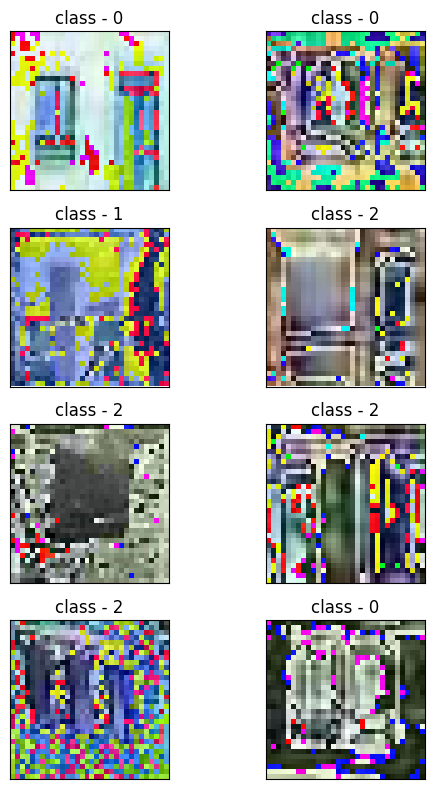

In [52]:
fig = plt.figure(figsize=(8,8))
for IMG, label in (look_flow):
    for i in range(8):
        fig.add_subplot(4, 2, i+1)
        plt.imshow(IMG[i].to(torch.uint8).permute(1, 2, 0))
        plt.title(f'class - {label[i]}')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    break

## Функция для обучения

In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
  since = time.time()
  with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
      print(f'Epoch {epoch}/{num_epochs - 1}')
      print('-' * 10)

      for phase in ['train', 'val']:
        if phase == 'train':
          model.train()  # Set model to training mode
        else:
          model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward
          # track history if only in train
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()

                    # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data) #пока accuracy, потом заменить на нужный score
        if phase == 'train':
          scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          torch.save(model.state_dict(), best_model_params_path)

      print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
  return model

In [24]:
model_rn = models.resnet18(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 61.7MB/s]


In [25]:
model_rn

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
num_ftrs = model_rn.fc.in_features
model_rn.fc = nn.Linear(num_ftrs, 3)

model_rn = model_rn.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_rn = optim.SGD(model_rn.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_rn, step_size=7, gamma=0.1)

In [29]:
model_rn = train_model(model_rn, criterion, optimizer_rn, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 0.7320 Acc: 0.6840
val Loss: 0.6088 Acc: 0.7563

Epoch 1/14
----------
train Loss: 0.5990 Acc: 0.7523
val Loss: 0.5429 Acc: 0.7815

Epoch 2/14
----------
train Loss: 0.5483 Acc: 0.7789
val Loss: 0.4911 Acc: 0.8007

Epoch 3/14
----------
train Loss: 0.5228 Acc: 0.7855
val Loss: 0.4919 Acc: 0.8066

Epoch 4/14
----------
train Loss: 0.5162 Acc: 0.7884
val Loss: 0.5029 Acc: 0.8073

Epoch 5/14
----------
train Loss: 0.5195 Acc: 0.7867
val Loss: 0.4871 Acc: 0.8089

Epoch 6/14
----------
train Loss: 0.5146 Acc: 0.7889
val Loss: 0.4804 Acc: 0.8119

Epoch 7/14
----------
train Loss: 0.5129 Acc: 0.7890
val Loss: 0.4876 Acc: 0.8093

Epoch 8/14
----------
train Loss: 0.5090 Acc: 0.7943
val Loss: 0.4772 Acc: 0.8107

Epoch 9/14
----------
train Loss: 0.5126 Acc: 0.7912
val Loss: 0.4678 Acc: 0.8150

Epoch 10/14
----------
train Loss: 0.5047 Acc: 0.7956
val Loss: 0.4768 Acc: 0.8138

Epoch 11/14
----------
train Loss: 0.5083 Acc: 0.7951
val Loss: 0.4796 Acc: 0.8098

Ep

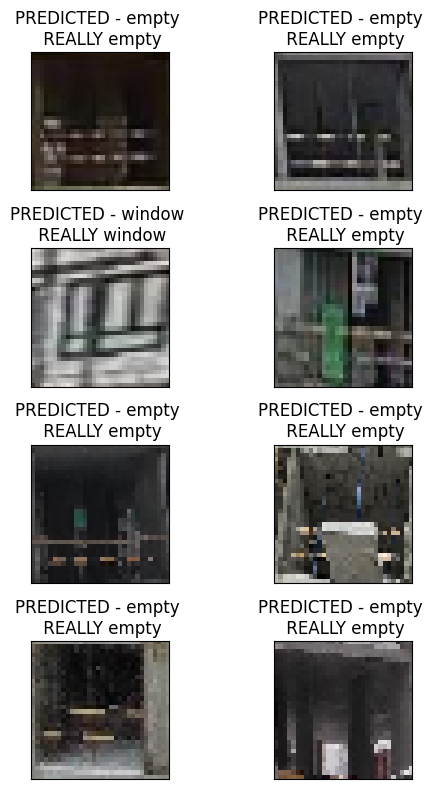

In [103]:
model_rn.eval()
idx = np.random.randint(0, description.shape[0], 8)
fig = plt.figure(figsize=(8,8))

for i in range(len(idx)):
  path = cellDir + description.loc[idx[i], :]['file']
  image = transforms.Resize((32, 32))(read_image(path).to(torch.float32))
  target = description.loc[idx[i], :]['target']
  with torch.no_grad():
    input = image.unsqueeze(0).to(device)
    outputs = model_rn(input)
    _, preds = torch.max(outputs, 1)
    fig.add_subplot(4, 2, i+1)
    plt.title(f'PREDICTED - {class_names[preds.cpu().detach().numpy()[0]]} \n REALLY {class_names[target]}')
    plt.imshow(image.to(torch.uint8).permute(1, 2, 0))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**[MobileNet](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/), в конце добавлен слой для классификации по 3 классам**

In [ ]:
#mnn = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
#mnn.eval()

In [ ]:
#mnn.classifier = nn.Sequential(nn.LazyLinear(3))
#for name, param in mnn.named_parameters():
#    if 'classifier' not in name:
#        print(name, param.requires_grad)
#        param.requires_grad=False
#for name, param in mnn.named_parameters():
#    print(name,param.requires_grad)
#mnn